<a href="https://colab.research.google.com/github/Minsung-commit/TIL/blob/master/ARIMA_%ED%8F%89%EC%B0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
visitors = pd.read_csv('./지역별 방문자수 비교_20210909.csv')

In [3]:
visitors = visitors[['년','월','일','외지인(b)']]

In [4]:
visitors.columns = ['year','month','day','visitors']

In [5]:
visitors

,year,month,day,visitors
0,2018,1,1,"198,425"
1,2018,1,2,"62,808"
2,2018,1,3,"57,057"
3,2018,1,4,"60,952"
4,2018,1,5,"65,642"
...,...,...,...,...
1338,2021,9,1,"52,224"
1339,2021,9,2,"61,478"
1340,2021,9,3,"77,690"
1341,2021,9,4,"114,804"


In [6]:
visitors['time'] = '{}-{}-{}'.format(visitors.year, visitors.month, visitors.day)

In [7]:
# 시계열 생성
time = []
for x in range(len(visitors)):
  a = '{}-{}-{}'.format(visitors.year[x], visitors.month[x], visitors.day[x])
  time.append(a)

In [8]:
visitors['time'] = time

In [9]:
visitors

,year,month,day,visitors,time
0,2018,1,1,"198,425",2018-1-1
1,2018,1,2,"62,808",2018-1-2
2,2018,1,3,"57,057",2018-1-3
3,2018,1,4,"60,952",2018-1-4
4,2018,1,5,"65,642",2018-1-5
...,...,...,...,...,...
1338,2021,9,1,"52,224",2021-9-1
1339,2021,9,2,"61,478",2021-9-2
1340,2021,9,3,"77,690",2021-9-3
1341,2021,9,4,"114,804",2021-9-4


In [10]:
#날짜형식 변환
visitors.time = pd.to_datetime(visitors.time, format = "")

In [11]:
prophet_visit = visitors.copy()

In [27]:
#인덱스 설정
visitors.index = visitors.time
visitors.set_index('time', inplace=True)

In [28]:
visitors.drop(['year','month','day'], inplace=True, axis=1) # year, month, day 컬럼 제거

In [29]:
visitors['visitors'] = visitors.visitors.replace(',', '')

In [30]:
visitors.visitors = visitors.visitors.str.replace(',', '').astype('int64')

In [64]:
visitors.dtypes # 시계열 자료 확인
# visitors = visitors.astype({'visitors':'int'})

visitors    int64
dtype: object

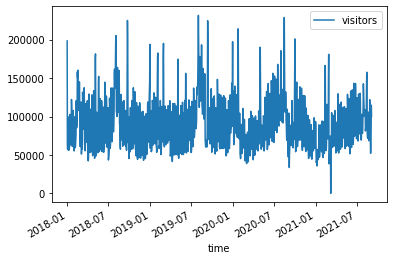

In [65]:
visitors.plot()
plt.show()

In [66]:
df = visitors.copy()

In [67]:
df = df.resample(rule='W').sum()

In [70]:
df

,visitors
time,
2018-01-07,635176
2018-01-14,502688
2018-01-21,573679
2018-01-28,535325
2018-02-04,511223
...,...
2021-08-08,756498
2021-08-15,748317
2021-08-22,647217


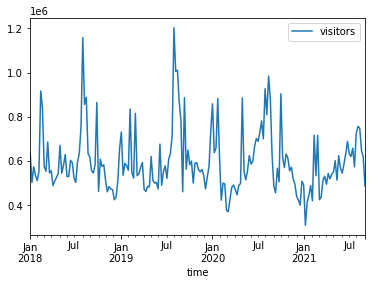

In [69]:
df.plot()
plt.show()

In [71]:
#ARIMA 모델 생성
model = ARIMA(df.visitors.values, order=(1,0,0), seasonal=(1,0,0))


TypeError: ignored

#Prophet 모델 

In [14]:
prophet_visit.drop(['year','month','day'], inplace=True, axis=1) # year, month, day 컬럼 제거
prophet_visit.visitors = visitors.visitors.str.replace(',', '').astype('int64')

In [148]:
prophet_visit

,y,ds
0,198425,2018-01-01
1,62808,2018-01-02
2,57057,2018-01-03
3,60952,2018-01-04
4,65642,2018-01-05
...,...,...
1338,52224,2021-09-01
1339,61478,2021-09-02
1340,77690,2021-09-03
1341,114804,2021-09-04


In [125]:
train_prophet = prophet_visit[:-59]
test_prophet = prophet_visit[-59:]

In [126]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
df_prophet.columns = ['y', 'ds']
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(train_prophet)

In [127]:
# 30일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=60, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1339,2021-09-01,89993.364325,56918.637955,122733.622010
1340,2021-09-02,91329.575931,58185.729477,122529.139680
1341,2021-09-03,107308.995848,69837.292610,143858.420931
1342,2021-09-04,153891.131168,111046.559808,199656.013586
1343,2021-09-05,138380.523488,96548.937752,175941.030611


In [135]:
values = future_data[-59:-5]

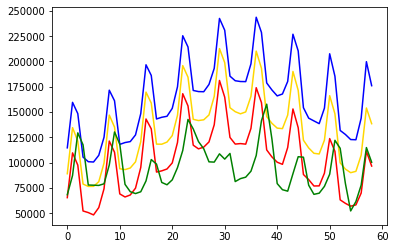

In [140]:
# 예측값 비교
pred_y = forecast_data[-59:].yhat.values # 마지막 5일의 예측 데이터입니다.
test_y = test_prophet[-59:].y.values # 실제 5일 방문자수 데이터입니다.
pred_y_lower = forecast_data.yhat_lower[-59:].values # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper[-59:].values # 마지막 5일의 예측 데이터의 최대값입니다.

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [61]:
test_prophet[-7:].y

1336    114076
1337     79180
1338     52224
1339     61478
1340     77690
1341    114804
1342    100327
Name: y, dtype: int64

In [118]:
y_pred = forecast_data[:5].yhat_lower
y = test_y[:5]

In [119]:
y_pred

0    42811.303076
1    40525.258386
2    41203.590257
3    42590.460097
4    54419.949656
Name: yhat_lower, dtype: float64

In [121]:
test_y

array([103408, 108973,  81224,  84143,  85561,  91466, 106967, 141281,
       157675, 123042,  79230,  73188,  71754,  88949, 105770, 105284,
        77620,  68600,  69737,  76471,  88487, 121975, 114076,  79180,
        52224,  61478,  77690, 114804, 100327])

In [122]:
pred_y

array([156748.45682088, 116430.09686889, 112853.37769631, 110801.74454767,
       112791.66317791, 127083.46769432, 167281.12522652, 152156.64787369,
       109480.18760158, 103825.11342328,  99815.48952531, 100012.94070671,
       112752.13340174, 151737.64698594, 135323.86447953,  91452.30490197,
        85062.63577902,  80598.32210338,  80641.60041463,  93574.04819518,
       133171.08649463, 117337.93248669,  74154.79816535,  68894.49895685,
        65786.95137646,  67402.93530715,  82140.41745137, 123817.32170176,
       109864.13592456])

In [113]:
# 성능 평가

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
MSE = mean_squared_error(y, y_pred)
RMSE = mean_squared_error(y, y_pred)**0.5
MAE = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
# r2_adj = 1-(1-r1)*(n-1)/(n-p-1)

In [114]:
print(MSE)
print(RMSE)
print(MAE)
print(r2)

2531012959.0291085
50309.17370648328
48351.687705746255
-18.9182371790394


In [111]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y, y_pred)

18.02886682663986

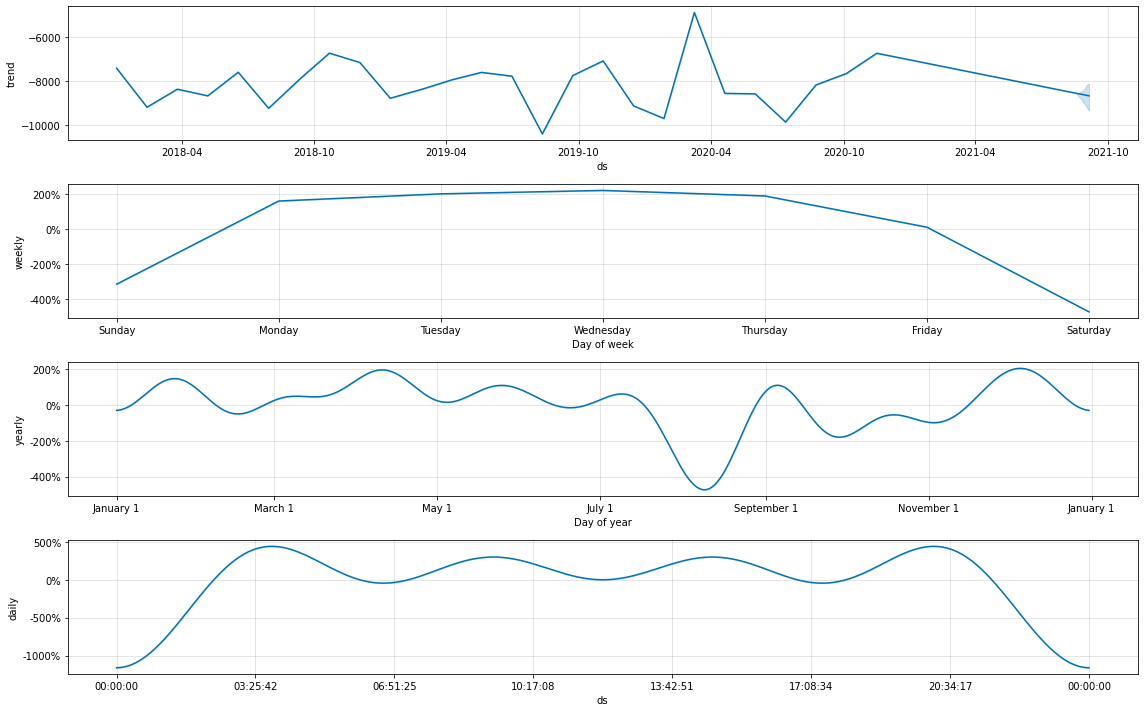

In [66]:
prophet.plot_components(forecast_data,figsize=(16,10))
plt.show()

## 계절성 추가

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


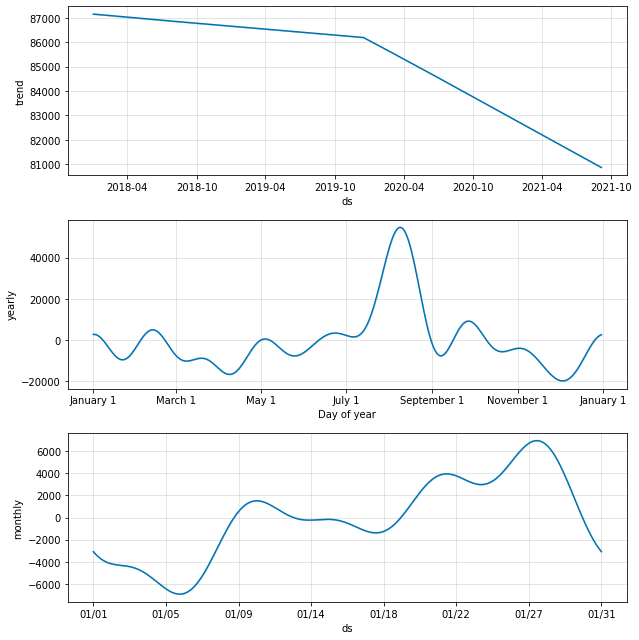

In [100]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(train_prophet).predict(future_data)
fig = m.plot_components(forecast)

In [101]:
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1339,2021-09-01,80893.467971,48936.055080,126183.864000,80890.582568,80895.842011,4649.195500,4649.195500,4649.195500,6939.695237,6939.695237,6939.695237,-2290.499738,-2290.499738,-2290.499738,0.0,0.0,0.0,85542.663471
1340,2021-09-02,80884.919394,41785.253085,122805.997003,80881.855378,80887.552423,2091.578079,2091.578079,2091.578079,6058.822289,6058.822289,6058.822289,-3967.244210,-3967.244210,-3967.244210,0.0,0.0,0.0,82976.497474
1341,2021-09-03,80876.370818,41899.139610,118933.608908,80873.237873,80879.219690,-2201.647092,-2201.647092,-2201.647092,3130.800754,3130.800754,3130.800754,-5332.447846,-5332.447846,-5332.447846,0.0,0.0,0.0,78674.723725
1342,2021-09-04,80867.822241,38300.496170,108029.439740,80864.439667,80870.951066,-6844.436469,-6844.436469,-6844.436469,-462.126975,-462.126975,-462.126975,-6382.309495,-6382.309495,-6382.309495,0.0,0.0,0.0,74023.385771
1343,2021-09-05,80859.273664,31426.419101,109038.265650,80855.581733,80862.578592,-10204.576372,-10204.576372,-10204.576372,-3085.930602,-3085.930602,-3085.930602,-7118.645770,-7118.645770,-7118.645770,0.0,0.0,0.0,70654.697292


In [103]:
y_pred2 = forecast[-5:].yhat
y2 = test_prophet[-5:].y

In [104]:
MSE = mean_squared_error(y2, y_pred2)
RMSE = mean_squared_error(y2, y_pred2)**0.5
MAE = mean_absolute_error(y2, y_pred2)
r2 = r2_score(y2, y_pred2)

In [105]:
print(MSE)
print(RMSE)
print(MAE)
print(r2)

823358490.960013
28694.22399996231
25250.96032134253
-0.5047293927406646


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
test = prophet_visit['visitors']

In [ ]:
# pip install git+https://github.com/statsmodels/statsmodels.git

In [16]:
from statsmodels.tsa.seasonal import STL

In [49]:
plt.rcParams['figure.figsize'] = (8,8)	

In [150]:
res = seasonal_decompose(prophet_visit['y'], freq = 144, model='multiplicative').fit()
ax=res.plot() 
plt.show()

ValueError: ignored

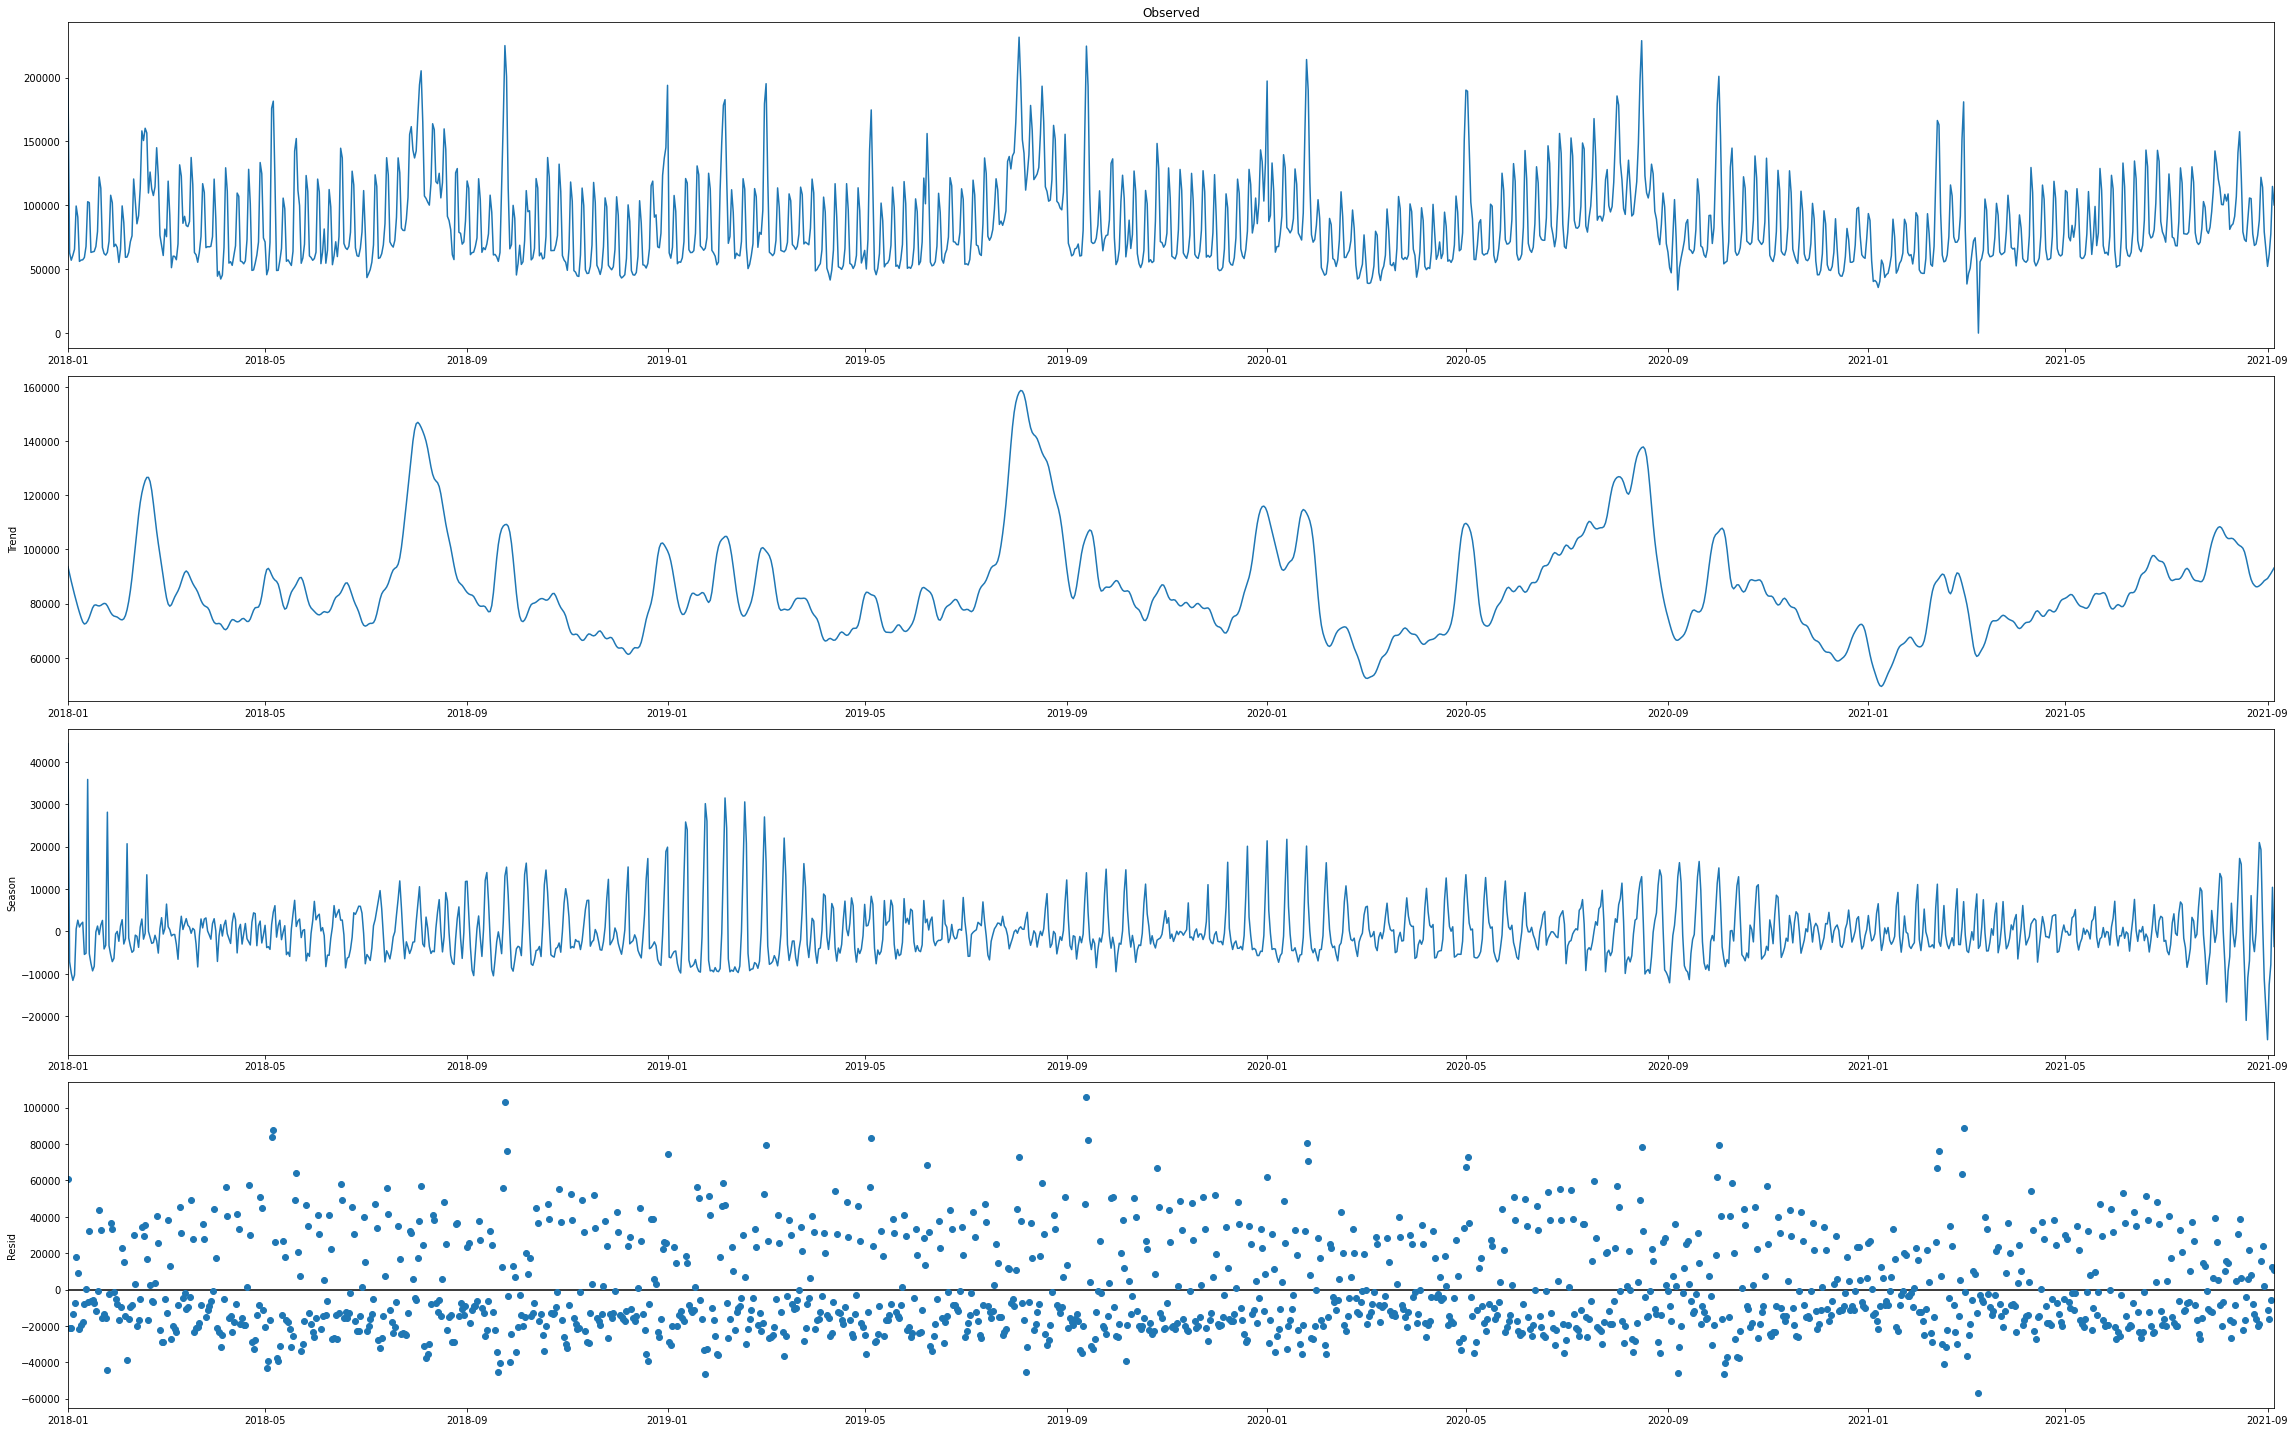

In [43]:

res = STL(visitors,seasonal=13,period=12).fit()

# fig = plt.figure(figsize=(32,20))
ax = res.plot()

plt.show()

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(visitors,model='multiplicative', period=12)
ax=res.plot()
plt.show()

ValueError: ignored

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


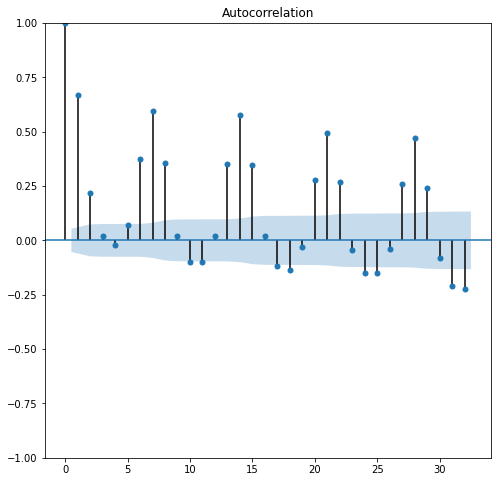

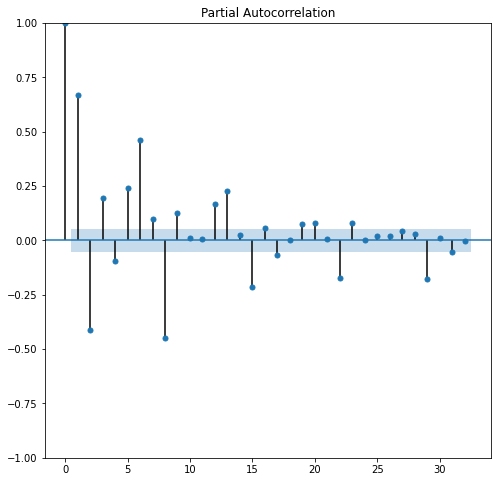

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(visitors)
plot_pacf(visitors)
plt.show()

In [71]:
diff_s = pd.diff(np.log(visitors),12)

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


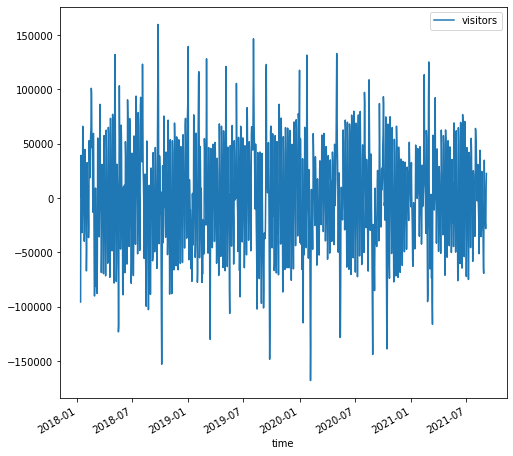

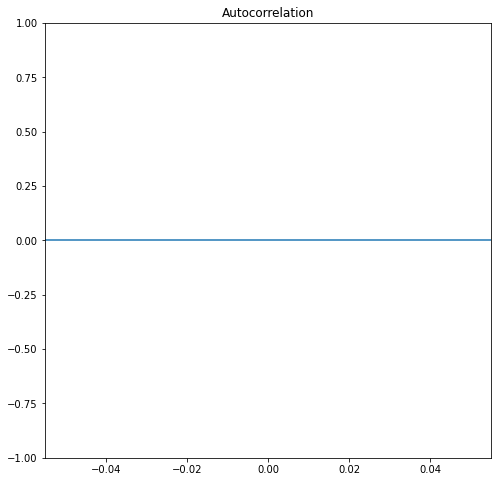

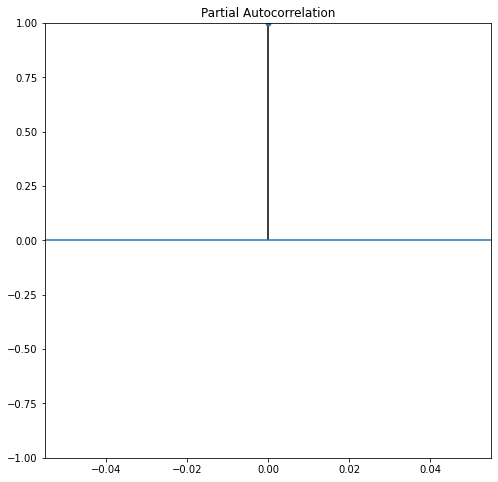

In [68]:
diff_1=visitors.diff(periods=12).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

계절형 ARIMA 모델 Auto ARIMA

In [53]:
pip install pmdarima

     |████████████████████████████████| 1.5 MB 5.1 MB/s 


In [55]:
from pmdarima.arima import auto_arima

In [56]:
stepwise_model = auto_arima(visitors, start_p=1, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=1, start_Q=0, max_P=3,max_Q=3, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=30902.693, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=31790.378, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=30881.796, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=34502.932, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=30879.841, Time=0.20 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=30877.948, Time=1.10 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=30878.010, Time=4.71 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=30877.863, Time=2.54 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=30872.452, Time=6.45 sec
 ARIMA(0,0,1)(3,0,1)[12] intercept   : AIC=30864.957, Time=17.28 sec
 ARIMA(0,0,1)(3,0,0)[12] intercept   : AIC=30864.477, Time=20.64 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=31708.348, Time=14.93 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=30649.346, Time=16.13 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=30647.664, Time=6.45 sec
 

In [60]:
#test, train set 분할 (2021-08-01 기준 분할)
train = visitors.loc['2018-01-01':'2021-08-01']
test = visitors.loc['2021-08-01':]
np.shape(test)

(35, 1)

In [59]:
stepwise_model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [61]:
future_forecast = stepwise_model.predict(n_periods=35)

In [64]:
test.index

DatetimeIndex(['2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08',
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16',
               '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20',
               '2021-08-21', '2021-08-22', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-28',
               '2021-08-29', '2021-08-30', '2021-09-01', '2021-09-02',
               '2021-09-03', '2021-09-04', '2021-09-05'],
              dtype='datetime64[ns]', name='time', freq=None)

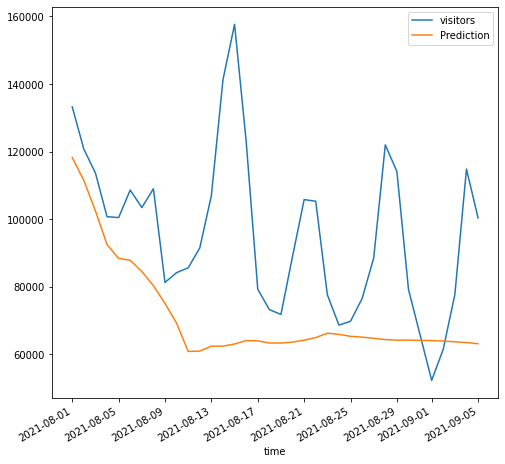

In [66]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()